# NYC 2018 Yellow Taxi Aggregation

This notebook is used to aggregate passenger counts for the NYC Yellow Taxi data (only 2018) found on the website:
https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

The data is aggregated by passenger counts on a daily basis.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
base_url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-{}.csv'

In [3]:
# this function just generates month codes based on the URL pattern
# essentially single digit months have a zero prefix
def month_generator():
    for i in range(1, 13):
        month = str(i)
        
        if len(month) == 1:
            month = '0{}'.format(month)
        
        yield month

In [4]:
# each month of data we resample it here
# note that some dates are not even in 2018 or the same month, those are thrown away
def resample_hourly(df, month):
    df = df.rename(columns={'tpep_pickup_datetime': 'pickup_datetime'})
    df['year'] = df['pickup_datetime'].apply(lambda s: s.split('-')[0])
    df['month'] = df['pickup_datetime'].apply(lambda s: s.split('-')[1])
    year_month_filter = (df['year'] == '2018') & (df['month'] == month)
    df = df[year_month_filter].copy()
    df = df.drop(columns=['year', 'month'])
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    df = df.set_index('pickup_datetime').sort_index()
    
    return df.resample('H').sum()

In [5]:
# read all csvs and concatenate them
dfs = []

# limit data to pickup date and time and the passenger count
# the data sets are fairly large ~1GB each and we only care to aggregate
columns = ['tpep_pickup_datetime', 'passenger_count']

for month in month_generator():
    url = base_url.format(month)
    df = pd.read_csv(url, usecols=columns)
    hourly_df = resample_hourly(df, month)
    dfs.append(hourly_df)

In [6]:
df = pd.concat(dfs)

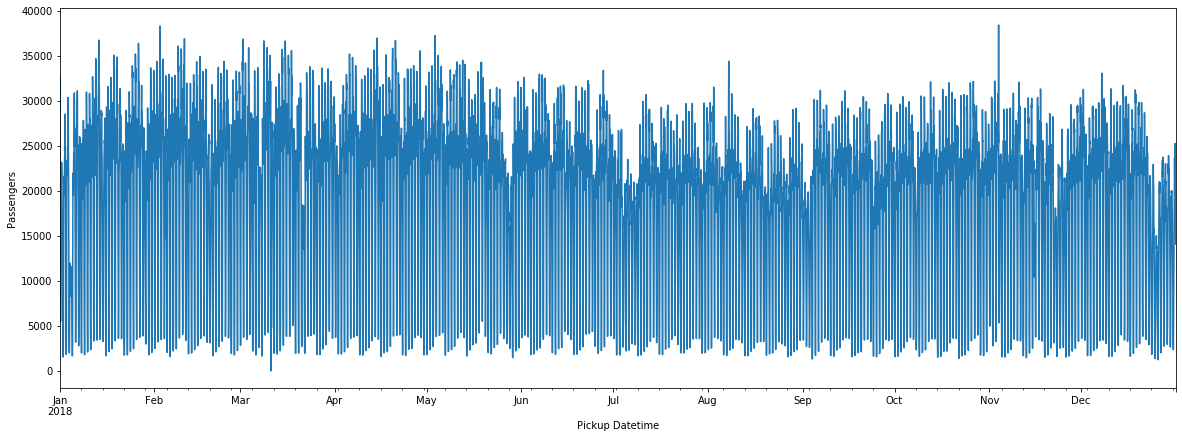

In [7]:
df.plot(figsize=(20,7), legend=None)
plt.xlabel('Pickup Datetime')
plt.ylabel('Passengers')
plt.show()

In [8]:
df.to_csv('data/nyc_yellow_taxi_passenger_count_2018_hourly.csv')